In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy as sp
import scipy.stats
import seaborn as sns
from matplotlib import cm
import networkx as nx
import pandas as pd
import itertools
from matplotlib import animation
import os
# Using matplotlib notebook allows you to interact with the resulting 3-D figure
%matplotlib inline

In [2]:
import sys
sys.path.append(r'src')
import curvgrad as cg
import trngln
from importlib import reload
reload(cg)
reload(trngln)

<module 'trngln' from 'src/trngln.py'>

In [3]:
# two methods for animation - see:
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
# 1 - directly inline via %matplotlib notebook - advantage: real-time, disadvantage: no manual control
# 2 - encode as video, embedded into notebook (base64) and display via notebook player or JS widget
#     downside - not real time, need to generate complete video before it can be displayed
# 2a - HTML(anim.to_html5_video())  [notebook player, bare bones] [uses html5 <video> tag]
# 2b - HTML(anim.to_jshtml())  [JS widget, extra controls]
# these latter can be made default representation via next line, which can also be 'html5'
mp.rcParams['animation.html'] = 'jshtml'
# 3 - save as an animated GIF and display using 
# rot_animation.save('rotation.gif', dpi=80, writer='imagemagick')
# ![RotatingImage](rotation.gif "Quadratic Form")
# see also https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531

In [4]:
refc = pd.read_csv('Data/mark_us_curv.csv', index_col = 0)
refc.columns = refc.columns.astype('float')

### Create the 3D Mesh and its Triangulation

First create a 2D x-y mesh

In [5]:
cellcoords = np.array(list(itertools.product(refc.index, refc.columns)), dtype='float')
# we assume that ncols = nrows in the input dataframe
gridsize = len(refc.columns)
x = np.reshape(cellcoords[:,0], (gridsize, gridsize))
y = np.reshape(cellcoords[:,1], (gridsize, gridsize))
z = np.zeros((gridsize, gridsize))
curvatures = np.reshape([refc.loc[x, y] for x, y in itertools.product(refc.index, refc.columns)], 
                        (gridsize, gridsize))

In [6]:
# x and y are the corresponding indices of a 2D mesh
# x, y = np.mgrid[-edge:edge:.05, -edge:edge:.05]
# create the structure needed for evaluating pdfs
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
gridsize = x.shape[0]

Now create the triangulation of the 3D mesh

In [7]:
Tr = trngln.trngln(gridsize)
triangles = Tr.triangles()

In [8]:
G = Tr.regularization_graph()
L = nx.laplacian_matrix(G)
L3 = L @ L @ L

In [9]:
t_of_v = Tr.triangles_of_vertex()

In [10]:
xf = x.flatten()
yf = y.flatten()
zf = z.flatten()

In [11]:
def get_triangle_vertices(triangles, xf, yf, zf):
    # this is the actual mesh we will plot
    return np.array([np.array([[xf[T[0]], yf[T[0]], zf[T[0]]],
                                    [xf[T[1]], yf[T[1]], zf[T[1]]],
                                    [xf[T[2]], yf[T[2]], zf[T[2]]]]) for T in triangles])
def get_vertices(xf, yf, zf):
    # list of coordinates of each triangle
    return np.array(list(zip(xf, yf, zf)))

triangle_vertices = get_triangle_vertices(triangles, xf, yf, zf)
vertices = get_vertices(xf, yf, zf)

#### Compute the angle of vertex $b$ in triangle $T$

Given a triangle with vertices $p_0, p_1, p_2$.   To compute the angle at vertex $p_0$:

Let $v = p_1 - p_0,$ $u = p_2 - p_0$.  Then $\theta = \cos^{-1}\frac{u^T v}{\Vert u\Vert \Vert v\Vert}$

In [12]:
def angle_of_b_in_t(b, T, vertices):
    '''
    for a vertex b which is an index into vertices
    and a triangle T (which is a triple)
    return the angle formed by the two triangles sides at vertex b
    '''
    others = [t for t in T if t != b]
    u = np.array(vertices[others[0]] - vertices[b])
    v = np.array(vertices[others[1]] - vertices[b])
    return np.arccos((u.T @ v) / (np.linalg.norm(u) * np.linalg.norm(v)))

#### Compute the curvature at vertex $b$.

The curvature at a vertex $= 2 \pi - \sum$ angles around vertex

In [13]:
def vertex_curvature(b, t_of_v, vertices):
    '''
    return the curvature at vertex b
    '''
    # find the angles of the edges incident at each vertex b
    # t_of_v[b] is the set of triangles incident to vertex b
    angles = [angle_of_b_in_t(b, t, vertices) for t in t_of_v[b]]
    if len(angles) == 6:
        # this is an interior vertex
        return 2 * np.pi - np.sum(angles)
    else:
        # this vertex does not have the standard number of neighbors (6)
        # which happens at the edge of the mesh
        # so just ignore it - will be filtered out of downstream processing
        return np.nan 
    
def get_curvature(vertices, t_of_v):
    '''
    return an array containing the curvature at each vertex in vertices
    '''
    return np.array([vertex_curvature(v, t_of_v, vertices) for v in range(len(vertices))])

In [14]:
def rmap(x, oldmin, newmin, oldmax, newmax, newzero):
    '''
    linear rescaling for visualization purposes
    rescale from range [oldmin, 0] to [newmin, newzero]
    and from [0, oldmax] to [newzero, newmax]
    '''
    if x > 0:
        return (x/oldmax)*(newmax-newzero)+newzero
    elif x < 0:
        return (x/oldmin)*(newmin-newzero)+newzero
    else:
        return newzero

## Warping a surface to match a curvature

### Build a test case

Get a curvature value for each point

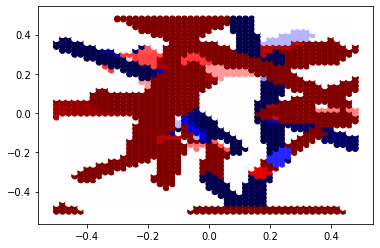

In [15]:
cmap = cm.seismic
maxscale = 0.1
plt.scatter(xf, yf, color = [cmap(rmap(p, -maxscale, 0, maxscale, 1, 0.5)) for p in curvatures.flatten()])

### Loss Function

Let the intended curvature at grid point $i$ be $\kappa(i)$ and the current curvature be $c(i)$.   Then to match the observed curvature, the loss is:

$$ \mathcal{L_{\mbox{curv}}} = \sum_i (\kappa(i) - c(i))^2. $$

#### Symmetry Breaking: Objective


However, note that there is a symmetry-breaking problem here.  From a starting point of a flat surface, we can get positive curvature at $i$ by moving $i_z$ either upwards or downwards.  


One way to think about this is in terms of the Laplace-Beltrami operator $\Delta$ applied to the $z$ coordinate.  $\Delta \mathbf{z}$ is positive at $(x, y, z)$ if that point is above the average of its neighbors, and negative if it is below the average of its neighbors.  We can consider these to correspond to "opening downward" (negative mean curvature) or "opening upward" (positive mean curvature).  Note that mean curvature here is different from the Gaussian curvature that we are trying to achieve in our optimization.

Hence, given a region where points all have (say) positive Gaussian curvature, we want those points to also have the same-sign (positive) mean curvature.  This will create "bumps" in regions of positive Gaussian curvature (rather than many little pockets of positive Gaussian, but alternating-sign mean curvature).  

We get an approximation to mean curvature from the Laplace-Beltrami operator.   And we will approximate the Laplace-Beltrami operator with the mesh's graph Laplacian (many details to go back and fix here!)  So we will look for smoothness in $L\mathbf{z}$. 

Note here the basic fact that  $x^TLx = \sum_{(u,v)\in E} (x(u) - x(v))^2.$   That is, the quadratic form $x^TLx$ measures how much adjacent points in a graph differ from each other in the values that are assigned to them.   That is, how non-smooth the $x$ values are on the graph.

  Our objective therefore will be to minimize $\mathbf{z}^TL^TLL\mathbf{z} = \mathbf{z}^TL^3\mathbf{z}$.

Hence our final loss function will be:

$$ \mathcal{L} = \sum_i (\kappa(i) - c(i))^2 + \lambda \mathbf{z}^TL^3\mathbf{z}. $$

#### Symmetry Breaking: Initialization

Also because of the symmetry problems, if we start with exactly $\mathbf{z} = 0$, the gradient of the above $\mathcal L$ with respect to $z$ is exactly zero.

We want to 'bias' the solution to always creating 'bumps' in the positive-curvature region, rather than a choice of either 'bumps' or 'dips'.  

Hence we initialize $\mathbf{z}$ to equal $\kappa$.  That means that positively curved regions will start as bumps (which will then be adjusted up or down by the optimization).

### Optimizing $\mathcal{L}$ by Gradient Descent

Each point has three coordinates, ie, $a = (x_a, y_a, z_a)$.  In order to use gradient descent to minimize this loss function we need to compute
$$ \frac{\partial \mathcal{L}}{\partial z} $$
where $z = [z_i]^T$.  Written out, the above is $[\frac{\partial \mathcal{L}}{\partial z_i}]^T$.

### Gradient

The gradient we seek is:

$$ \frac{\partial \mathcal{L}}{\partial z} = \sum_i 2(\kappa(i) - c(i))\left(-\frac{\partial c(i)}{\partial z}\right) + \lambda L^3z$$.

Details on computing the terms in the gradient, ie, $\frac{\partial c(i)}{\partial z}$, are omitted but are listed in another notebook.

### Functions for computing gradient

In [16]:
# test case
kappa = curvatures.flatten()

In [17]:
zf = 0.001 * curvatures.flatten()
# zf = 0.001 * np.random.random(576)
vertices = get_vertices(xf, yf, zf)
c = get_curvature(vertices, t_of_v)

In [18]:
def objfn(kappa, c):
    '''
    return a measure of how much the actual curvature differs from the
    desired curvature
    '''
    diff = kappa-c
    diff = diff * diff
    return np.nansum(diff)

def complete_objfn(kappa, c, smooth_pen, penval):
    '''
    return the objective function of the optimization, ie,
    taking into account both the curvature error and the smoothness penalty
    '''
    ob = objfn(kappa, c)
    return ob + smooth_pen * penval

In [19]:
def single_step(smooth_pen, rate, vertices, kappa, cv_in, t_of_v, xf, yf, zf):
    grad = cg.L_grad_penalized(smooth_pen, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    # grad, penalty = L_grad_penalized_with_convexity(100, L, zf, 10, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    # grad = L_grad_penalized_biased(10, 10, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    new_zf = zf - rate * grad
    new_vertices = get_vertices(xf, yf, new_zf)
    new_cv = get_curvature(new_vertices, t_of_v)
    return new_zf, new_cv, new_vertices, grad

def single_step_with_momentum(prev_step, momentum, smooth_pen, rate, vertices, kappa, cv_in, t_of_v, xf, yf, zf):
    grad = cg.L_grad_penalized(smooth_pen, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    prev_step = ((1-momentum) * grad) + (momentum * prev_step)
    new_zf = zf - rate * prev_step
    new_vertices = get_vertices(xf, yf, new_zf)
    new_cv = get_curvature(new_vertices, t_of_v)
    return new_zf, new_cv, new_vertices, prev_step

In [20]:
def generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, t_of_v, niter = 1000, verbose = False):
    '''
    generate the surface that matches the curvature given by kappa
        kappa: desired curvature at each point of the mesh - 1D array
        smooth_pen: the weight applied to non-smoothness; 
            larger values produce smoother surfaces
        rate: initial learning rate, which will be adjusted during optimization
        momentum: the momentum parameter, typically between 0.9 and 0.99
        xf, yf: the x and y coordinates of the mesh as 1D arrays
        t_of_v: dictionary giving the triangles that touch at each vertex of the mesh
        niter: number of iterations of gradient descent
    '''  
    # we initialize the z coordinate to be equal to the curvature
    # this is explained above under "symmetry breaking: initialization"
    zf = kappa.copy()
    zf[np.isnan(zf)] = 0
    zf[zf<0] = 0
    #
    # initialize variables that will be used in gradient descent
    vertices = get_vertices(xf, yf, zf)
    cv = get_curvature(vertices, t_of_v)
    of = objfn(kappa, cv)
    cof = complete_objfn(kappa, cv, smooth_pen, zf.T @ L3 @ zf)
    old_of = of
    old_cof = cof
    errvals = []
    c_errvals = []
    #
    # initial rate - decrease rate until a single step does not increase the objective
    if verbose:
        print('starting rate setting: rate: {} obj fn: {} complete obj fn: {}'.format(rate, of, cof))   
    new_zf, new_cv, new_vertices, prev_step = single_step(smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
    while (complete_objfn(kappa, new_cv, smooth_pen, new_zf.T @ L3 @ new_zf) > old_cof):
        rate = rate / 1.1
        new_zf, new_cv, new_vertices, prev_step = single_step(smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
        if verbose:
            print('setup: -- lowering rate to {}'.format(rate))
    old_cof = complete_objfn(kappa, new_cv, smooth_pen, new_zf.T @ L3 @ new_zf)
    old_of = objfn(kappa, new_cv)
    zf = new_zf
    cv = new_cv
    vertices = new_vertices
    if verbose:
        print('finished rate setting: rate: {} obj fn: {} complete obj fn: {}'.format(rate, old_of, old_cof))
    #
    # main loop
    for i in range(niter):
        #
        # perform a single step of gradient descent, with momentum
        new_zf, new_cv, new_vertices, prev_step = single_step_with_momentum(prev_step, momentum,
            smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
        of = objfn(kappa, new_cv)
        cof = complete_objfn(kappa, new_cv, smooth_pen, new_zf.T @ L3 @ new_zf)
        #
        # if this step increased the objective function, decrease the learning rate
        if (cof > old_cof):
            rate = rate / 1.1
            if verbose:
                print('step: {} -- lowering rate to {}'.format(i, rate))
        #
        # if rate has gone so low that no progress at all is being made, increase it
        elif (cof == old_cof):
            rate = rate * 1.1
            if verbose:
                print('step: {} -- raising rate to {}'.format(i, rate))
        #
        # else this was a successful step that decreased the objective function
        # so save the results (zf) and statistics
        else:
            errvals.append(of)
            c_errvals.append(cof)
            old_of = of
            old_cof = cof
            zf = new_zf
            cv = new_cv
            vertices = new_vertices
            if (0 == i % 100):
                if verbose:
                    print('step: {}, obj fn: {}'.format(i, of))
    if verbose:
        print('Done: final error: {}'.format(of))
    return zf, cv, errvals, c_errvals

In [21]:
def document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize):
    # error plots
    plt.figure()
    plt.plot(errvals, '-')
    plt.yscale('log')
    plt.suptitle('Loss for Curvature Only')
    plt.title(runname)
    plt.savefig('{}/curvature-error.png'.format(runname))
    #
    plt.figure()
    plt.plot(c_errvals, '-')
    plt.yscale('log')
    plt.suptitle('Complete Objective Function')
    plt.title(runname)
    plt.savefig('{}/objective-function.png'.format(runname))
    #
    plt.figure()
    sns.heatmap(np.reshape(kappa, (gridsize, gridsize)), cmap = cm.bwr, vmin = -1, vmax = 1, center = 0)
    plt.suptitle('Target Curvature Map')
    plt.title(runname)
    plt.savefig('{}/target-curvature-map.png'.format(runname))
    #
    plt.figure()
    sns.heatmap(np.reshape(cv, (gridsize, gridsize)), cmap = cm.bwr, vmin = -1, vmax = 1, center = 0)
    plt.suptitle('Output Curvature Map')
    plt.title(runname)
    plt.savefig('{}/output-curvature-map.png'.format(runname))

In [22]:
def generate_plots(runname, gridsize, xf, yf, zf, cv, locnamefile, refc):
    # first visualize colored with curvature
    fig = plt.figure(figsize = (12, 12))
    ax = fig.add_subplot(111, projection='3d')
    x = np.reshape(xf, (gridsize, gridsize))
    y = np.reshape(yf, (gridsize, gridsize))
    z = np.reshape(zf, (gridsize, gridsize))
    cvcol = cv.copy()
    cvcol[np.isnan(cvcol)] = 0
    maxscale = .5
    cvcol = cmap([rmap(p, -  maxscale, 0, maxscale, 1, 0.5) for p in cvcol])
    cvcol = np.reshape(cvcol, (gridsize, gridsize, 4))
    ax.plot_surface(x, y, z, facecolors = cvcol)
    plt.savefig('{}/surface-with-curvature.png'.format(runname))
    #
    # now visualize with solid color and location names
    fig = plt.figure(figsize = (12, 12))
    ax = fig.add_subplot(111, projection='3d')
    ls = mp.colors.LightSource(azdeg = 270, altdeg = 30)
    ax.view_init(azim = 315, elev = 75)
    plt.axis('off')
    ax.plot_surface(x, y, z, rcount = gridsize, ccount = gridsize, color='skyblue', lightsource = ls) #, facecolors = cvcol, lightsource = ls)
    labels = pd.read_csv(locnamefile)
    x_axis_vals = list(refc.columns.values)
    y_axis_vals = list(refc.index.values)
    for i in labels.iterrows():
        lbl = i[1][0]
        xpt = i[1][1]
        ypt = i[1][2]
        xndx = x_axis_vals.index(i[1][1])
        yndx = y_axis_vals.index(i[1][2])
        zpt = z[yndx, xndx]
        ax.text(ypt, xpt, zpt, lbl, color='red')
    plt.savefig('{}/surface-with-labels.png'.format(runname))
    #
    # generate animated gif
    def rotate(angle):
        ax.view_init(azim = angle, elev = 75)
        
    rot_animation = animation.FuncAnimation(fig, 
                                        rotate, 
                                        frames=np.arange(0,360,5), 
                                        interval=100, 
                                        repeat=False)
    plt.close()
    fname = '{}/animation.gif'.format(runname)
    rot_animation.save(fname, dpi=80, writer='imagemagick')

In [23]:
rate = 0.0001
smooth_pen = 50
momentum = 0.9
niter = 1000

In [ ]:
zf, cv, errvals, c_errvals = generate_surface(smooth_pen, rate, momentum, kappa, xf, yf, 
                                              t_of_v, niter = niter, verbose = True)
runname = 'Output/sp{:d}i{:d}'.format(smooth_pen, niter)
try:
    os.mkdir(runname)
except FileExistsError:
    pass
document_run(runname, zf, cv, errvals, c_errvals, kappa, gridsize)
generate_plots(runname, gridsize, xf, yf, zf, cv, 'Data/map_points.csv', refc)

starting rate setting: rate: 0.0001 obj fn: 2053.772845995889 complete obj fn: 298098.48261225934
setup: -- lowering rate to 9.09090909090909e-05
setup: -- lowering rate to 8.264462809917355e-05
setup: -- lowering rate to 7.513148009015777e-05
setup: -- lowering rate to 6.830134553650706e-05
setup: -- lowering rate to 6.20921323059155e-05
setup: -- lowering rate to 5.644739300537773e-05
setup: -- lowering rate to 5.131581182307066e-05
setup: -- lowering rate to 4.665073802097332e-05
setup: -- lowering rate to 4.240976183724847e-05
setup: -- lowering rate to 3.8554328942953155e-05
setup: -- lowering rate to 3.504938994813923e-05
finished rate setting: rate: 3.504938994813923e-05 obj fn: 4582.376587219471 complete obj fn: 255949.3358837016
step: 0 -- lowering rate to 3.1863081771035665e-05
step: 1 -- lowering rate to 2.8966437973668783e-05
step: 2 -- lowering rate to 2.633312543060798e-05
step: 3 -- lowering rate to 2.3939204936916344e-05
step: 4 -- lowering rate to 2.1762913579014857e-0